In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pysam

BASEDIR = "/data1/shahs3/users/sunge/cnv_simulator"
DATADIR = f"{BASEDIR}/data"

## Plot simulated ground-truth CNV profiles

In [5]:
# Load CNV profile data
test_name = "minitest_c1_1"
cnv_profile_df = pd.read_csv(f"{DATADIR}/small_cnv_profiles/{test_name}_cnv_profile.tsv", sep="\t")

cnv_profile_df

,clone,chr,start,end,copy_number,state,size,cell_barcode,cell_group
0,1,1,0,86271456,0,2,86271456.0,"128708A-R42-C29,128640A-R56-C52,128640A-R44-C1...","12,12,12,12,12,12,12,12,12,12"
1,1,1,86271456,88271456,8,10,2000000.0,"128640A-R13-C29,128640A-R14-C54,128640A-R16-C1...","12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,1..."
2,1,1,88271456,89621519,0,2,1350063.0,"128708A-R42-C29,128640A-R56-C52,128640A-R44-C1...","12,12,12,12,12,12,12,12,12,12"
3,1,1,89621519,91621519,11,13,2000000.0,"128640A-R14-C27,128640A-R15-C13,128640A-R17-C2...","12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,1..."
4,1,1,91621519,249250621,0,2,157629102.0,"128708A-R42-C29,128640A-R56-C52,128640A-R44-C1...","12,12,12,12,12,12,12,12,12,12"


1


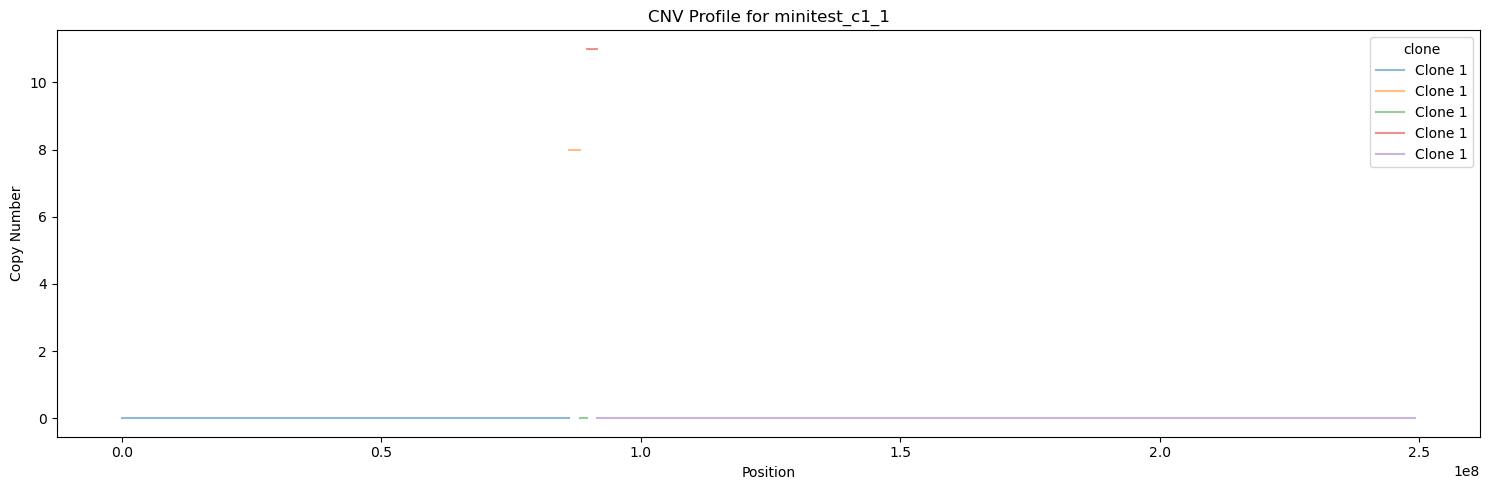

In [ ]:
chr_lengths = 

plt.figure(figsize = (15, 5))
for clone in cnv_profile_df["clone"].unique():
    print(clone)
    clone_df = cnv_profile_df[cnv_profile_df["clone"] == clone]
    for _, row in clone_df.iterrows():
        plt.plot([row["start"], row["end"]], [row["copy_number"]] * 2,
                 label = f"Clone {clone}",
                 alpha = 0.5)
plt.xlabel("Position")
plt.ylabel("Copy Number")
plt.title(f"CNV Profile for {test_name}")
plt.legend(title = "clone")
plt.tight_layout()
plt.show()